In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import datetime as dt
from sklearn import preprocessing
from sklearn import linear_model
import warnings
warnings.filterwarnings('ignore')


In [2]:
india_data = pd.read_csv("./dataset/covid19-in-india/covid_19_india.csv")


In [3]:
# india_data.tail()

#### change date to date type
#### remove confirrmed foreign national


In [4]:
india_data['Date'] = pd.to_datetime(india_data['Date'], dayfirst = True)

In [5]:
le = preprocessing.LabelEncoder()
india_data['Day_num'] = le.fit_transform(india_data.Date)
india_data['Day'] = india_data['Date'].dt.day
india_data['Month'] = india_data['Date'].dt.month
india_data['Year'] = india_data['Date'].dt.year
india_data['State/UnionTerritory'] = le.fit_transform(india_data['State/UnionTerritory'])
number_c = india_data['State/UnionTerritory']
states = le.inverse_transform(india_data['State/UnionTerritory'])
state_dict = dict(zip(states, number_c))

india_data[['Confirmed', 'Cured', 'Deaths']] = india_data[['Confirmed', 'Cured', 'Deaths']].astype('float64')
india_data[['Confirmed', 'Cured', 'Deaths']] = india_data[['Confirmed', 'Cured', 'Deaths']].apply(lambda x: np.log1p(x))
india_data.replace([np.inf, -np.inf], 0, inplace=True)

In [6]:
india_data = india_data.drop(columns=['Time', 'ConfirmedForeignNational','ConfirmedIndianNational', 'Year'])

In [7]:
# india_data.isnull().sum()

In [8]:
# rajData = india_data.loc[india_data['State/UnionTerritory'] == state_dict['Rajasthan']]
# plt.figure(figsize = (14,8))
# sns.barplot(data = rajData, x = 'Day_num', y = 'Confirmed', color = 'red')
# sns.barplot(data = rajData, x = 'Day_num', y = 'Cured', color = 'green')
# sns.barplot(data = rajData, x = 'Day_num', y = 'Deaths', color = 'orange')

In [9]:
def train_test_split_custom(df, start_day, train_lim, test_lim):
    
    X_train = df.loc[df['Day_num'] <= train_lim]
    X_train = X_train[X_train['Day_num'] > start_day]
    X_test = df.loc[df['Day_num'] <= test_lim]
    X_test = X_test.loc[X_test['Day_num'] > train_lim]
    
    y_train = X_train['Confirmed']
    y_test = X_test['Confirmed']
    
    X_train = X_train.drop(['Confirmed', 'Deaths', 'Cured'], axis = 1)
    X_test = X_test.drop(['Confirmed','Deaths', 'Cured'], axis = 1)
    
    return X_train, y_train, X_test, y_test

In [10]:
X_train, y_train, X_test, y_test = train_test_split_custom(india_data, 20, 70, 90)

In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(780, 6)
(780,)
(645, 6)
(645,)


In [12]:
def lin_reg(X_train, Y_train, X_test):
    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, Y_train)

    # Make predictions using the testing set
    y_pred = regr.predict(X_test)
    
    return regr, y_pred

In [13]:
def plot_state(data, state_name, start_date, train_lim, test_lim):
    state_data = data[data['State/UnionTerritory'] == state_dict[state_name]]
    X_train, y_train, X_test, y_test = train_test_split_custom(state_data, start_date, train_lim, test_lim)
    print("X_test.shape", X_test.shape)
    print("y_test.shape", y_test.shape)
    X_train['Date']=X_train['Date'].map(dt.datetime.toordinal)
    X_test['Date']=X_test['Date'].map(dt.datetime.toordinal)

    
    model, pred = lin_reg(X_train, y_train, X_test)
    
    plt.plot(X_test['Day_num'], np.expm1(y_test), color = 'blue')
    plt.plot(X_test['Day_num'], np.expm1(pred), color = 'green')
    plt.show()

X_test.shape (10, 6)
y_test.shape (10,)


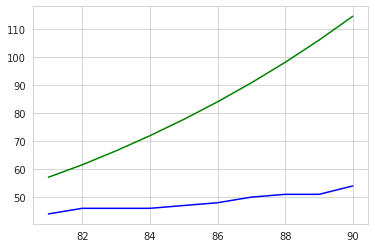

In [82]:
plot_state(india_data, 'Uttarakhand', 20, 80, 90)

In [15]:
india_data.head()

,Sno,Date,State/UnionTerritory,Cured,Deaths,Confirmed,Day_num,Day,Month
0,1,2020-01-30,16,0.0,0.0,0.693147,0,30,1
1,2,2020-01-31,16,0.0,0.0,0.693147,1,31,1
2,3,2020-02-01,16,0.0,0.0,1.098612,2,1,2
3,4,2020-02-02,16,0.0,0.0,1.386294,3,2,2
4,5,2020-02-03,16,0.0,0.0,1.386294,4,3,2


#### Calc lags and trends
#### Use data of prev 20 days to predict 21st day
#### Add 21st day to training data
#### Use its previous 20 days to predict 22nd and so on! till you read end of the testing data



In [16]:
# 80 corrosponds to 19 april

In [17]:
def calculate_lag(df, lag_list, column):
    for lag in lag_list:
        column_lag = column + "_" + str(lag)
        df[column_lag] = df.groupby(['State/UnionTerritory'])[column].shift(lag, fill_value=0)
    return df

def calculate_trend(df, lag_list, column):
    for lag in lag_list:
        trend_column_lag = "Trend_" + column + "_" + str(lag)
        df[trend_column_lag] = (df.groupby(['State/UnionTerritory'])[column].shift(0, fill_value=0) - 
                                df.groupby(['State/UnionTerritory'])[column].shift(lag, fill_value=0))/df.groupby(['State/UnionTerritory'])[column].shift(lag, fill_value=0.001)
    return df

In [18]:
def split_data_one_day(df, start_date, d, train_lim, test_lim):
    X_train = df[df['Day_num'] >= start_date]
    X_train = X_train[X_train['Day_num'] < train_lim]
    
    y_train = X_train['Confirmed']
    X_train = X_train.drop(columns = ['Confirmed', 'Cured', 'Deaths', 'Sno'])
    X_test = df[df['Day_num'] == d]
    y_test = X_test['Confirmed']
    X_test = X_test.drop(columns = ['Confirmed', 'Cured', 'Deaths', 'Sno'])
    
    return X_train, y_train, X_test, y_test

In [19]:
X_train, y_train, X_test, y_test = split_data_one_day(india_data[india_data['State/UnionTerritory'] == state_dict['Rajasthan']], 60, 81, 80, 90 )


In [63]:
def lin_reg_with_lags_state(data, state_name, start_date, lag_size, state_dict, train_lim, test_lim):
    state_data = data[data['State/UnionTerritory'] == state_dict[state_name]]
    
    #compute lags
    state_data = calculate_lag(state_data, range(1, lag_size), 'Confirmed')
    state_data = calculate_trend(state_data, range(1, 8), 'Confirmed')
    data.replace([np.inf, -np.inf], 0, inplace=True)
    data.fillna(0, inplace=True)
    
    tr_lim = train_lim
    ts_lim = test_lim
    y_test_data = []
    y_pred_data = []
    dayd = []
    
    for d in list(range(train_lim, test_lim)):
        X_train, y_train, X_test, y_test = split_data_one_day(state_data, start_date, d, tr_lim, ts_lim)
        X_train['Date']=X_train['Date'].map(dt.datetime.toordinal)
        X_test['Date']=X_test['Date'].map(dt.datetime.toordinal)
        model, pred = lin_reg(X_train, y_train, X_test)
        print(y_test.values)
        state_data.loc[state_data['Day_num'] == d, 'Confirmed'] = pred
        
        state_data = calculate_lag(state_data, range(1, lag_size), 'Confirmed')
        state_data = calculate_trend(state_data, range(1, 8), 'Confirmed')
        
        y_test_data.append(np.expm1(y_test.values))
        y_pred_data.append(np.expm1(pred))
        dayd.append(d)
        tr_lim += 1
        start_date += 1
        
    return y_pred_data, y_test_data, dayd
    
    
y_pred_data, y_test_data, dayd = lin_reg_with_lags_state(india_data, 'Rajasthan', 60, 15, state_dict, 80, 91)
        
    


[7.20934026]
[7.29912146]
[7.36327959]
[7.49665244]
[7.54486107]
[7.58324752]
[7.6182511]
[7.6420444]
[7.68982867]
[7.72444665]
[7.7685333]


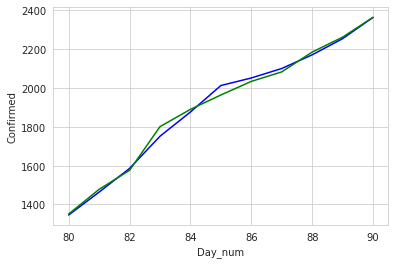

In [64]:
plt.plot(dayd, y_pred_data, color = 'blue')
plt.plot(dayd, y_test_data, color = 'green')
plt.ylabel('Confirmed')
plt.xlabel('Day_num')
plt.show()
# print(y_test_data)

In [65]:
def create_df(data, dayCount):
    state = data['State/UnionTerritory']
    state = state.values[0]
    lastDate = max(data['Date'])
    cols = data.columns
    lastDay_num = max(data['Day_num'])
    lastDay = max(data['Day'])
    
    start_date = lastDate + dt.timedelta(days=1)
    curr_day_num = lastDay_num + 1
    curr_day = lastDay + 1
    df = pd.DataFrame(columns = cols)
#     df1 = pd.Series([99999, start_date, state, 0.0, 0.0, 0.0 curr_day_num, curr_day, 3 ], index = cols)
    for i in range(1, dayCount):
        df1 = pd.Series([99999, start_date, state, 0.0, 0.0, 0.0, curr_day_num, curr_day, 5 ], index = cols)  
        df = df.append(df1, ignore_index = True)
        start_date = start_date + dt.timedelta(days = 1)
        curr_day_num += 1
        curr_day += 1
        
    return df

In [66]:
def pred_future_confirmed(data, state_name, lag_size, state_dict):
        state_data = data[data['State/UnionTerritory'] == state_dict[state_name]]
        train_lim = max(state_data['Day_num'])
        extra_state_data = create_df(state_data, 15)
        state_data = state_data.append(extra_state_data)
        test_lim = max(state_data['Day_num'])
        
        state_data = calculate_lag(state_data, range(1, lag_size), 'Confirmed')
        state_data = calculate_trend(state_data, range(1, 8), 'Confirmed')
        data.replace([np.inf, -np.inf], 0, inplace=True)
        data.fillna(0, inplace=True)
        
        tr_lim = train_lim
        ts_lim = test_lim
        y_test_data = []
        y_pred_data = []
        dayd = []
        start_date = train_lim - 10
        
        
        
        for d in list(range(train_lim, test_lim)):
#             print('start_date = ', start_date, ' d = ', d, ' tr_lim = ', tr_lim,)
            X_train, y_train, X_test, y_test = split_data_one_day(state_data, start_date, d, tr_lim, ts_lim)
#             print(X_test.columns)
            X_train['Date']=X_train['Date'].map(dt.datetime.toordinal)
            X_test['Date']=X_test['Date'].map(dt.datetime.toordinal)
            model, pred = lin_reg(X_train, y_train, X_test)
#             print((pred))
            state_data.loc[state_data['Day_num'] == d , 'Confirmed'] = pred
#             print(state_data.loc[state_data['Day_num'] == d])
#             state_data.loc[state_data['Day_num'] == d] = calculate_lag(state_data.loc[state_data['Day_num'] == d], range(1, lag_size), 'Confirmed')
#             state_data.loc[state_data['Day_num'] == d] = calculate_trend(state_data.loc[state_data['Day_num'] == d], range(1, 8), 'Confirmed')
            state_data = calculate_lag(state_data, range(1, lag_size), 'Confirmed')
            state_data = calculate_trend(state_data, range(1, 8), 'Confirmed')
#             print(state_data.loc[state_data['Day_num'] == d, 'Confirmed'])
            y_test_data.append(np.expm1(y_test.values))
            y_pred_data.append(np.expm1(pred))
            dayd.append(d)
            tr_lim += 1
            start_date += 1
        
        return y_pred_data, y_test_data, dayd

       

In [67]:
y_pred_next, y_test_next, dayd_next = pred_future_confirmed(india_data, 'Rajasthan', 40, state_dict )

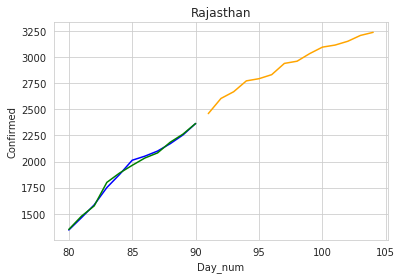

In [68]:
# plt.plot(dayd, y_pred_data, color = 'blue')
# plt.plot(dayd, y_test_data, color = 'green')
plt.plot(dayd, y_pred_data, color = 'blue')
plt.plot(dayd, y_test_data, color = 'green')
plt.plot(dayd_next, y_pred_next, color = 'orange')

plt.ylabel('Confirmed')
plt.xlabel('Day_num')
plt.title('Rajasthan')
plt.show()

[7.54644627]
[7.60290046]
[7.64108425]
[7.67647365]
[7.71824095]
[7.77359447]
[7.83002808]
[7.87321705]
[7.97899637]
[8.04205641]
[8.1062129]


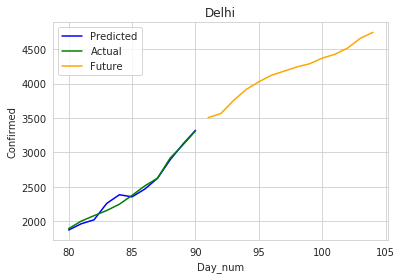

In [76]:
y_pred_data, y_test_data, dayd = lin_reg_with_lags_state(india_data, 'Delhi', 60, 15, state_dict, 80, 91)
y_pred_next, y_test_next, dayd_next = pred_future_confirmed(india_data, 'Delhi', 40, state_dict )
plt.plot(dayd, y_pred_data, color = 'blue', label = 'Predicted')
plt.plot(dayd, y_test_data, color = 'green', label = 'Actual')
plt.plot(dayd_next, y_pred_next, color = 'orange', label = 'Future')
plt.legend(loc = 'upper left')

plt.ylabel('Confirmed')
plt.xlabel('Day_num')
plt.title('Delhi')
plt.show()

[3.76120012]
[3.80666249]
[3.8501476]
[3.8501476]
[3.8501476]
[3.87120101]
[3.8918203]
[3.93182563]
[3.95124372]
[3.95124372]
[4.00733319]


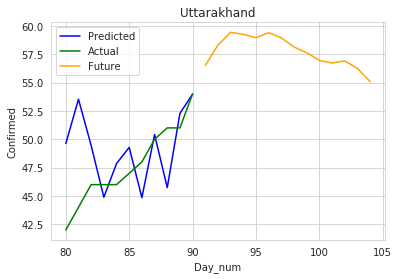

In [78]:
y_pred_data, y_test_data, dayd = lin_reg_with_lags_state(india_data, 'Uttarakhand', 60, 15, state_dict, 80, 91)
y_pred_next, y_test_next, dayd_next = pred_future_confirmed(india_data, 'Uttarakhand', 40, state_dict )
plt.plot(dayd, y_pred_data, color = 'blue', label = 'Predicted')
plt.plot(dayd, y_test_data, color = 'green', label = 'Actual')
plt.plot(dayd_next, y_pred_next, color = 'orange' , label = 'Future')
plt.legend(loc = 'upper left')

plt.ylabel('Confirmed')
plt.xlabel('Day_num')
plt.title('Uttarakhand')
plt.show()

[5.99396143]
[5.99893656]
[6.01371516]
[6.0591232]
[6.08449941]
[6.10702289]
[6.11368218]
[6.12905021]
[6.15273269]
[6.18001665]
[6.18826412]


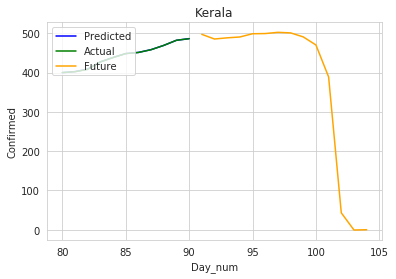

In [81]:
y_pred_data, y_test_data, dayd = lin_reg_with_lags_state(india_data, 'Kerala', 60, 15, state_dict, 80, 91)
y_pred_next, y_test_next, dayd_next = pred_future_confirmed(india_data, 'Kerala', 40, state_dict )
plt.plot(dayd, y_pred_data, color = 'blue', label = 'Predicted')
plt.plot(dayd, y_test_data, color = 'green', label = 'Actual')
plt.plot(dayd_next, y_pred_next, color = 'orange' , label = 'Future')
plt.legend(loc = 'upper left')

plt.ylabel('Confirmed')
plt.xlabel('Day_num')
plt.title('Kerala')
plt.show()